Finetuning hyperparameters

ROC AUC

Modes: 2 (BN, MC)
Rs: 4 (0,3,6,9)

LRs: 4 (2E-5, 1E-5, 2E-6, 1E-6)
Epochs: 5 (5, 10, 15, 20, #) [mc needs more epochs]

Metrics: 3 (Accuracy+F1, Accuracy+Recall, Recall+F1)
Batch: 2 (16, 32)
Loss: 3 (Default, Custom loss function with weighting, BCE weighted loss)

Confusion matrices

In [9]:
import os, json
cwd = os.getcwd() # should be base directory of repository
import time
import torch
from datasets import DatasetDict, Dataset
output_dir = cwd+"/outputs/fting"
input_dir = cwd+"/inputs/"

In [10]:
# uncomment if you dont already have the dataset dictionaries generated
'''
from classifier.finetune import load_labelintdcts, create_dsdict, create_om_dsdict
from classifier.run_classifiers import group_duplicates, remove_duplicates, dcno_to_sentlab
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
        dcno_json = json.load(f)
with open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)
sents1, labels1 = dcno_to_sentlab(dcno_json)
sents2, labels2 = dcno_to_sentlab(qry_json)
# merge original and augmented datasets
sents2.extend(sents1)
labels2.extend(labels1)
all_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))
int2label_dct, label2int_dct = load_labelintdcts()
sims = range(10)
#create_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)
create_om_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)
'''

'\nfrom classifier.finetune import load_labelintdcts, create_dsdict, create_om_dsdict\nfrom classifier.run_classifiers import group_duplicates, remove_duplicates, dcno_to_sentlab\nwith open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:\n        dcno_json = json.load(f)\nwith open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:\n    qry_json = json.load(f)\nsents1, labels1 = dcno_to_sentlab(dcno_json)\nsents2, labels2 = dcno_to_sentlab(qry_json)\n# merge original and augmented datasets\nsents2.extend(sents1)\nlabels2.extend(labels1)\nall_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))\nint2label_dct, label2int_dct = load_labelintdcts()\nsims = range(10)\n#create_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)\ncreate_om_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)\n'

First we're going to train our baseline model and get a view of the training progress in a ROC analysis

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc(labels, probs, mode, rstate, output_dir, int2label):
    if mode=="bn":
        fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        #
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='teal')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()
    elif mode=="mc":
        n_classes = probs.shape[1]
        y_test_bin = label_binarize(labels, classes=range(n_classes))
        # Compute ROC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot all
        plt.figure()
        colors = ['firebrick', 'darkorange', 'gold', 'yellowgreen', "deepskyblue", "slateblue"]
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {int2label[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()
    else:
        n_classes = probs.shape[1]
        y_test_bin = label_binarize(labels, classes=range(n_classes))
        # Compute ROC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot all
        plt.figure()
        colors = ['firebrick', 'darkorange', 'gold', 'yellowgreen', "deepskyblue", "slateblue", "mediumorchid"]
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {int2label[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
import evaluate
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
import numpy as np
import torch.nn as nn
from classifier.finetune import finetune_roberta, load_labelintdcts
import gc
import wandb
''''''

class WeightedTrainer(Trainer):
    def __init__(self, *args, loss_ratio=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_ratio = loss_ratio
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):#):#
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Define class weights and loss
        weights = torch.tensor(self.loss_ratio).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def finetune_roberta(datasetdct, int2label, label2int, mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=f"{os.getcwd()}/outputs/models", hyperparams=False, report_to="none"):
    '''
    '''
    if not hyperparams:
        hyperparams = {
            "epochs":10, 
            "r":9,
            "lr":2e-5,
            "batch_size":16,
            "loss":False,
            "oversampling":False
            }
    epochs = hyperparams["epochs"]
    rstate = hyperparams["r"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    loss_ratio = hyperparams["loss"]
    ovs_ratio = hyperparams["oversampling"]
    start = time.time()
    num_lbs = len(list(int2label))
    print(f'\nLoading model {model_name}\n')
    print("Tokenizing")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True).to(dev)
    tokenized_test = datasetdct["test"].map(preprocess_function, batched=True)
    if not ovs_ratio:
        tokenized_train = datasetdct["train"].map(preprocess_function, batched=True)
    else:
        train_sents = datasetdct["train"]["text"]
        train_labels = datasetdct["train"]["label"]
        ros = RandomOverSampler(sampling_strategy='auto', random_state=rstate)
        train_texts_resampled, train_labels_resampled = ros.fit_resample(np.array(train_sents).reshape(-1, 1), np.array(train_labels))
        train_texts_resampled, train_labels_resampled = shuffle(train_texts_resampled, train_labels_resampled, random_state=rstate)
        flattened_texts = list(train_texts_resampled.flatten())
        conv_dct = {"text":flattened_texts, "label":train_labels_resampled}
        conv_ds = Dataset.from_dict(conv_dct)
        tokenized_train = conv_ds.map(preprocess_function, batched=True)
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    recall = evaluate.load("recall")
    metric_log = []
    def calc_metrics(pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        metrics = {
            "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
            #"f1": f1.compute(predictions=predictions, references=labels, average="weighted" if mode=="mc" else "binary")["f1"],
            "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
            "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
        }
        metric_log.append(metrics)
        return metrics
    print("Loading model")
    #
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_lbs,id2label=int2label, label2id=label2int).to(dev)
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        seed=9,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="best",
        logging_strategy="epoch",
        optim="adamw_torch",
        load_best_model_at_end=True,
        report_to= report_to,
        run_name=f"{output_dir.split('_')[-2]}{rstate}" if report_to == "wandb" else "X"
    )
    #
    if loss_ratio:
        trainer = WeightedTrainer(
            loss_ratio=loss_ratio,
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_test,
            processing_class=tokenizer,
            compute_metrics=calc_metrics,
            #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
        )
    else:
        trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_test,
                processing_class=tokenizer,
                compute_metrics=calc_metrics,
            )
    print("Training")
    trainer.train()
    train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    eval_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    print("Saving")
    model_fn = f"{model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.pt"
    trainer.save_model(output_dir+f"/{model_fn}")
    #
    tokenized_ho = datasetdct["holdout"].map(preprocess_function, batched=True)
    predictions = trainer.predict(tokenized_ho)
    logits = predictions.predictions
    labels = predictions.label_ids
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    #
    plot_roc(labels, probs, mode, rstate, output_dir, int2label)
    metric_log.append({"train_loss":train_losses})
    metric_log.append({"eval_loss": eval_losses})
    metrics = calc_metrics((logits, labels))
    with open(output_dir+f"/{model_fn}/metrics.json", "w", encoding="utf-8") as f:
        json.dump(metric_log, f, ensure_ascii=False, indent=4)
    end = time.time()
    print(metrics)
    print(f"\nSaved {model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.")
    print(f'\nDone in {round((end-start)/60,2)} min')
    return metrics


Here we create all of our finetuned models

In [ ]:
!pip install wandb
!wandb login ###########################

^C


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\allie\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
os.environ["WANDB_PROJECT"]="fting_incentives"
os.environ["WANDB_LOG_MODEL"]="checkpoint"
os.environ["WANDB_WATCH"]="false"

int2label_dct, label2int_dct = load_labelintdcts()
metriclog = {}
exps = [0,3,6]#range(10)#[6]#[0,3,6,9]#
torch.cuda.empty_cache()
gc.collect()

for r in exps:
    output_dir = cwd+"/outputs/fting_I_om"
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_om")
    hyper = {
        "epochs":3, 
        "r":r, 
        "lr":2E-5,
        "batch_size":8,
        "loss":[0.175,8.81,2.57,2.78,25.3,10.7,3.32],
        "oversampling":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    wandbrun = wandb.init(config=hyper, group="I", name=f"I{r}", reinit='create_new')
    metrics = finetune_roberta(ds, int2label_dct["om"], label2int_dct["om"], "om", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, report_to="wandb")
    wandbrun.finish()
    metriclog[f'om_{r}'] = metrics
    hyp_rpt = {"om":hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)
'''
for r in exps:
    output_dir = cwd+"/outputs/fting_J_om"
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_om")
    hyper = {
        "epochs":10, 
        "r":r, 
        "lr":2E-5,
        "batch_size":8,
        "loss":None,
        "oversampling":"auto"
        }
    torch.cuda.empty_cache()
    gc.collect()
    wandbrun = wandb.init(config=hyper, group="J", name=f"J{r}", reinit='create_new')
    metrics = finetune_roberta(ds, int2label_dct["om"], label2int_dct["om"], "om", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, report_to="wandb")
    wandbrun.finish()
    metriclog[f'om_{r}'] = metrics
    hyp_rpt = {"om":hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)
'''
print(metriclog)


Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.654800,1.279524,0.764085,0.774290,0.764085
2,0.943000,0.964896,0.813380,0.817319,0.813380
3,0.620500,0.922653,0.806338,0.815575,0.806338


wandb: Adding directory to artifact (c:\Users\allie\Documents\GitHub\policy-classifier\outputs\fting_I_om\checkpoint-107)... Done. 5.7s
wandb: Adding directory to artifact (c:\Users\allie\Documents\GitHub\policy-classifier\outputs\fting_I_om\checkpoint-214)... Done. 7.5s



Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.861100,1.737008,0.753521,0.754021,0.753521
2,1.562200,1.483366,0.774648,0.783939,0.774648
3,1.264400,1.250750,0.732394,0.762224,0.732394
4,1.003500,1.097045,0.739437,0.767234,0.739437
5,0.774300,0.998110,0.750000,0.775889,0.750000
6,0.603100,0.937647,0.774648,0.795606,0.774648
7,0.461700,0.947190,0.785211,0.803294,0.785211
8,0.387800,1.025869,0.809859,0.817448,0.809859
9,0.357400,0.964448,0.802817,0.815740,0.802817
10,0.312900,0.992758,0.806338,0.817073,0.806338


Saving


{'accuracy': 0.7746478873239436, 'f1': 0.7996038547257043, 'recall': 0.7746478873239436}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r0.

Done in 9.04 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.862300,1.747692,0.746479,0.756787,0.746479
2,1.618800,1.510157,0.686620,0.720250,0.686620
3,1.332200,1.278773,0.700704,0.735448,0.700704
4,1.055000,1.105833,0.753521,0.778765,0.753521
5,0.812400,1.006361,0.767606,0.791774,0.767606
6,0.669600,0.929207,0.767606,0.793419,0.767606
7,0.529500,0.925781,0.778169,0.801119,0.778169
8,0.425200,0.912716,0.788732,0.810689,0.788732
9,0.384100,0.929373,0.795775,0.817255,0.795775
10,0.371900,0.971426,0.795775,0.815623,0.795775


Saving


{'accuracy': 0.795774647887324, 'f1': 0.8205584784086624, 'recall': 0.795774647887324}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r1.

Done in 10.79 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.858000,1.750719,0.700704,0.726724,0.700704
2,1.555600,1.553351,0.774648,0.778989,0.774648
3,1.290200,1.305230,0.683099,0.724210,0.683099
4,1.058600,1.134594,0.693662,0.731734,0.693662
5,0.798100,1.026872,0.697183,0.733561,0.697183
6,0.625500,0.948992,0.697183,0.733373,0.697183
7,0.532600,0.944323,0.718310,0.749436,0.718310
8,0.438300,0.999814,0.746479,0.773839,0.746479
9,0.410100,0.983960,0.750000,0.776061,0.750000
10,0.364600,1.012747,0.767606,0.790493,0.767606


Saving


{'accuracy': 0.8098591549295775, 'f1': 0.8291109090564451, 'recall': 0.8098591549295775}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r2.

Done in 9.71 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.875200,1.711130,0.669014,0.703189,0.669014
2,1.638800,1.473556,0.750000,0.766958,0.750000
3,1.337000,1.244092,0.665493,0.713886,0.665493
4,1.084500,1.060366,0.697183,0.738115,0.697183
5,0.863000,0.916007,0.693662,0.737930,0.693662
6,0.658100,0.832867,0.711268,0.751229,0.711268
7,0.538600,0.791636,0.735915,0.768508,0.735915
8,0.466500,0.772642,0.739437,0.770288,0.739437
9,0.390200,0.752078,0.750000,0.779798,0.750000
10,0.373400,0.806888,0.788732,0.806942,0.788732


Saving


{'accuracy': 0.8028169014084507, 'f1': 0.8224258840059074, 'recall': 0.8028169014084507}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r3.

Done in 9.65 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.877000,1.779164,0.721831,0.722597,0.721831
2,1.579900,1.532919,0.654930,0.696285,0.654930
3,1.257400,1.208078,0.683099,0.724260,0.683099
4,1.029300,1.043448,0.721831,0.756652,0.721831
5,0.760400,0.944486,0.739437,0.774630,0.739437
6,0.620500,0.942676,0.760563,0.790339,0.760563
7,0.509300,0.868335,0.746479,0.778675,0.746479
8,0.439700,0.891642,0.774648,0.800055,0.774648
9,0.349400,0.919129,0.785211,0.808178,0.785211
10,0.368800,0.936692,0.802817,0.822576,0.802817


Saving


{'accuracy': 0.8063380281690141, 'f1': 0.8255379339208131, 'recall': 0.8063380281690141}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r4.

Done in 9.73 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.868900,1.735452,0.788732,0.786410,0.788732
2,1.569700,1.466902,0.816901,0.829427,0.816901
3,1.264800,1.243991,0.792254,0.813647,0.792254
4,1.040900,1.083734,0.760563,0.789978,0.760563
5,0.820500,0.985922,0.806338,0.825291,0.806338
6,0.651600,0.942103,0.827465,0.842698,0.827465
7,0.516600,0.992335,0.866197,0.873567,0.866197
8,0.443600,0.973894,0.855634,0.865096,0.855634
9,0.373400,1.030731,0.869718,0.874994,0.869718
10,0.344100,1.037997,0.866197,0.868936,0.866197


Saving


{'accuracy': 0.778169014084507, 'f1': 0.8042175072317089, 'recall': 0.778169014084507}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r5.

Done in 9.09 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.855900,1.761576,0.778169,0.759836,0.778169
2,1.588200,1.478039,0.711268,0.744702,0.711268
3,1.248100,1.237880,0.725352,0.761077,0.725352
4,0.995500,1.033236,0.753521,0.785995,0.753521
5,0.813300,0.924864,0.746479,0.779769,0.746479
6,0.609000,0.990060,0.799296,0.818932,0.799296
7,0.489300,0.895313,0.785211,0.810334,0.785211
8,0.423600,0.905058,0.806338,0.827131,0.806338
9,0.368500,0.955751,0.813380,0.832141,0.813380
10,0.331800,0.962969,0.809859,0.828874,0.809859


Saving


{'accuracy': 0.778169014084507, 'f1': 0.8018674928218107, 'recall': 0.778169014084507}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r6.

Done in 9.83 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.873400,1.723774,0.771127,0.761537,0.771127
2,1.604000,1.458659,0.757042,0.777903,0.757042
3,1.312200,1.218618,0.735915,0.768477,0.735915
4,1.057300,1.030177,0.750000,0.777070,0.750000
5,0.826200,0.895378,0.778169,0.800633,0.778169
6,0.648300,0.813170,0.774648,0.797172,0.774648
7,0.507100,0.757688,0.816901,0.833634,0.816901
8,0.435500,0.779325,0.834507,0.847710,0.834507
9,0.375900,0.777208,0.841549,0.852689,0.841549
10,0.340900,0.773539,0.838028,0.847354,0.838028


Saving


{'accuracy': 0.7992957746478874, 'f1': 0.820264939309057, 'recall': 0.7992957746478874}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r7.

Done in 9.79 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.884100,1.741207,0.714789,0.745020,0.714789
2,1.571600,1.442654,0.683099,0.726629,0.683099
3,1.273400,1.169647,0.619718,0.674196,0.619718
4,1.019400,0.950675,0.742958,0.775655,0.742958
5,0.792400,0.817667,0.739437,0.773097,0.739437
6,0.638900,0.746100,0.820423,0.838956,0.820423
7,0.521600,0.693465,0.816901,0.837445,0.816901
8,0.418900,0.676133,0.845070,0.861335,0.845070
9,0.383100,0.686686,0.866197,0.878123,0.866197
10,0.336600,0.692547,0.866197,0.877688,0.866197


Saving


{'accuracy': 0.8098591549295775, 'f1': 0.8239246193015396, 'recall': 0.8098591549295775}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r8.

Done in 10.0 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,1.860200,1.763081,0.774648,0.753490,0.774648
2,1.600300,1.505703,0.750000,0.768911,0.750000
3,1.257500,1.252512,0.672535,0.717794,0.672535
4,1.008600,1.096687,0.658451,0.704592,0.658451
5,0.775800,0.969223,0.767606,0.796093,0.767606
6,0.641100,0.883431,0.788732,0.810584,0.788732
7,0.503100,0.854246,0.802817,0.821274,0.802817
8,0.428400,0.829634,0.816901,0.830032,0.816901
9,0.373300,0.929522,0.830986,0.838157,0.830986
10,0.340900,0.888364,0.827465,0.837128,0.827465


Saving


{'accuracy': 0.8415492957746479, 'f1': 0.8539688934522467, 'recall': 0.8415492957746479}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r9.

Done in 9.18 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.656100,0.669182,0.813380,0.828271,0.813380
2,0.048900,0.694462,0.862676,0.853788,0.862676
3,0.013900,0.741041,0.869718,0.863343,0.869718
4,0.006600,0.806489,0.862676,0.855314,0.862676
5,0.004500,0.842136,0.862676,0.857353,0.862676
6,0.003400,0.868079,0.866197,0.861182,0.866197
7,0.002800,0.892419,0.862676,0.854893,0.862676
8,0.002400,0.900602,0.869718,0.865333,0.869718
9,0.002100,0.910111,0.869718,0.865333,0.869718
10,0.002000,0.913381,0.869718,0.865333,0.869718


Saving


{'accuracy': 0.7992957746478874, 'f1': 0.8184596193307251, 'recall': 0.7992957746478874}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r0.

Done in 43.16 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.670800,0.715968,0.809859,0.827677,0.809859
2,0.054100,0.689351,0.852113,0.854760,0.852113
3,0.019400,0.789085,0.845070,0.850995,0.845070
4,0.007800,0.907697,0.834507,0.845758,0.834507
5,0.004700,0.866144,0.838028,0.843083,0.838028
6,0.003500,0.883160,0.838028,0.843083,0.838028
7,0.002800,0.905518,0.838028,0.843083,0.838028
8,0.002400,0.917293,0.838028,0.843083,0.838028
9,0.002200,0.926696,0.838028,0.843083,0.838028
10,0.002000,0.932336,0.838028,0.843083,0.838028


Saving


{'accuracy': 0.8873239436619719, 'f1': 0.881611205398868, 'recall': 0.8873239436619719}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r1.

Done in 48.76 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.658600,0.749157,0.774648,0.789685,0.774648
2,0.051100,0.794422,0.823944,0.827520,0.823944
3,0.017900,0.848623,0.834507,0.839617,0.834507
4,0.006700,0.928680,0.830986,0.835081,0.830986
5,0.005300,0.966525,0.834507,0.837836,0.834507
6,0.003500,1.017532,0.834507,0.839439,0.834507
7,0.002800,1.041981,0.834507,0.839439,0.834507
8,0.002400,1.062338,0.834507,0.839439,0.834507
9,0.002200,1.075469,0.834507,0.839439,0.834507
10,0.002100,1.077880,0.834507,0.839439,0.834507


Saving


{'accuracy': 0.8380281690140845, 'f1': 0.847059365733412, 'recall': 0.8380281690140845}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r2.

Done in 41.43 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.664400,0.516190,0.830986,0.839660,0.830986
2,0.054400,0.513899,0.883803,0.875961,0.883803
3,0.015500,0.564645,0.880282,0.872397,0.880282
4,0.006700,0.612630,0.876761,0.869731,0.876761
5,0.004500,0.644310,0.876761,0.869731,0.876761
6,0.003400,0.670516,0.876761,0.869731,0.876761
7,0.002800,0.687293,0.876761,0.869731,0.876761
8,0.002400,0.702586,0.873239,0.866430,0.873239
9,0.002100,0.710010,0.873239,0.866700,0.873239
10,0.002000,0.713440,0.873239,0.866430,0.873239


Saving


{'accuracy': 0.8802816901408451, 'f1': 0.8775623033045549, 'recall': 0.8802816901408451}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r3.

Done in 41.05 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.655200,0.614681,0.802817,0.819895,0.802817
2,0.060800,0.580537,0.869718,0.862779,0.869718
3,0.017500,0.671430,0.869718,0.866029,0.869718
4,0.006800,0.717587,0.866197,0.864039,0.866197
5,0.004700,0.754067,0.866197,0.865542,0.866197
6,0.003500,0.782941,0.866197,0.865542,0.866197
7,0.002800,0.802546,0.866197,0.865542,0.866197
8,0.002400,0.826829,0.869718,0.868148,0.869718
9,0.002200,0.831885,0.866197,0.866397,0.866197
10,0.002100,0.835441,0.866197,0.866397,0.866197


Saving


{'accuracy': 0.8908450704225352, 'f1': 0.8852751657405667, 'recall': 0.8908450704225352}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r4.

Done in 45.43 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.659800,0.486599,0.859155,0.869576,0.859155
2,0.055400,0.439330,0.908451,0.901314,0.908451
3,0.015600,0.544275,0.894366,0.890221,0.894366
4,0.006900,0.597699,0.890845,0.878890,0.890845
5,0.004600,0.572023,0.904930,0.897469,0.904930
6,0.003500,0.583540,0.904930,0.899862,0.904930
7,0.002800,0.605324,0.904930,0.899862,0.904930
8,0.002400,0.606970,0.904930,0.899862,0.904930
9,0.002100,0.609887,0.904930,0.899862,0.904930
10,0.002000,0.610376,0.904930,0.899862,0.904930


Saving


{'accuracy': 0.8802816901408451, 'f1': 0.8741559586205894, 'recall': 0.8802816901408451}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r5.

Done in 40.9 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.661300,0.692874,0.792254,0.815060,0.792254
2,0.046200,0.564335,0.869718,0.864125,0.869718
3,0.012900,0.653829,0.866197,0.864153,0.866197
4,0.006500,0.703024,0.862676,0.861475,0.862676
5,0.004500,0.713688,0.866197,0.864153,0.866197
6,0.003400,0.741373,0.862676,0.861475,0.862676
7,0.002700,0.763664,0.862676,0.861475,0.862676
8,0.002300,0.779928,0.862676,0.861475,0.862676
9,0.002100,0.792011,0.862676,0.861475,0.862676
10,0.002000,0.794726,0.862676,0.861475,0.862676


Saving


{'accuracy': 0.8873239436619719, 'f1': 0.8767793826288812, 'recall': 0.8873239436619719}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r6.

Done in 45.36 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.673300,0.494570,0.848592,0.849721,0.848592
2,0.050700,0.515358,0.873239,0.874342,0.873239
3,0.015600,0.553348,0.873239,0.875613,0.873239
4,0.007300,0.557128,0.887324,0.884657,0.887324
5,0.004600,0.578224,0.887324,0.885488,0.887324
6,0.003500,0.594487,0.890845,0.889875,0.890845
7,0.002800,0.607859,0.887324,0.886550,0.887324
8,0.002400,0.620491,0.887324,0.886550,0.887324
9,0.002200,0.627570,0.887324,0.886550,0.887324
10,0.002000,0.623830,0.890845,0.889626,0.890845


Saving


{'accuracy': 0.8415492957746479, 'f1': 0.8484091293263398, 'recall': 0.8415492957746479}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r7.

Done in 45.07 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.676000,0.454251,0.873239,0.881935,0.873239
2,0.057700,0.397872,0.911972,0.902147,0.911972
3,0.018100,0.460146,0.915493,0.908636,0.915493
4,0.008000,0.492876,0.908451,0.900205,0.908451
5,0.004700,0.517526,0.911972,0.905177,0.911972
6,0.003500,0.534920,0.911972,0.905177,0.911972
7,0.002800,0.548243,0.911972,0.905177,0.911972
8,0.002400,0.557031,0.908451,0.902036,0.908451
9,0.002200,0.563771,0.908451,0.902036,0.908451
10,0.002100,0.566002,0.908451,0.902036,0.908451


Saving


{'accuracy': 0.8873239436619719, 'f1': 0.8821654170124301, 'recall': 0.8873239436619719}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r8.

Done in 46.18 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/4858 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.660600,0.557999,0.830986,0.844296,0.830986
2,0.049000,0.526621,0.873239,0.862769,0.873239
3,0.013800,0.580963,0.883803,0.871294,0.883803
4,0.007800,0.629767,0.880282,0.869690,0.880282
5,0.004500,0.667050,0.887324,0.876819,0.887324
6,0.003400,0.700380,0.883803,0.872553,0.883803
7,0.002800,0.704292,0.880282,0.870067,0.880282
8,0.002400,0.705850,0.883803,0.874092,0.883803
9,0.002100,0.717454,0.887324,0.877400,0.887324
10,0.002000,0.720478,0.883803,0.873373,0.883803


Saving


{'accuracy': 0.8732394366197183, 'f1': 0.8721618463177677, 'recall': 0.8732394366197183}

Saved paraphrase-xlm-r-multilingual-v1_om_e10_r9.

Done in 41.88 min


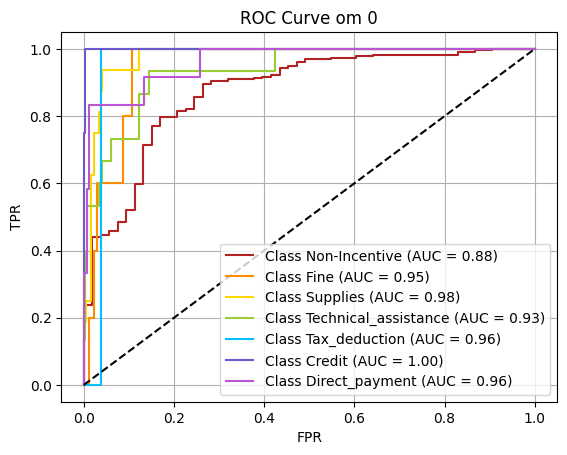

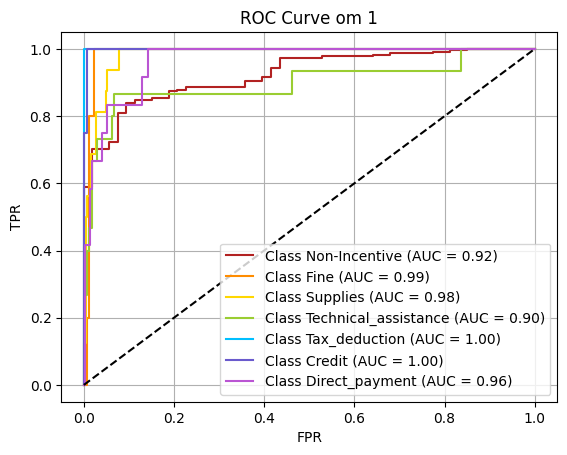

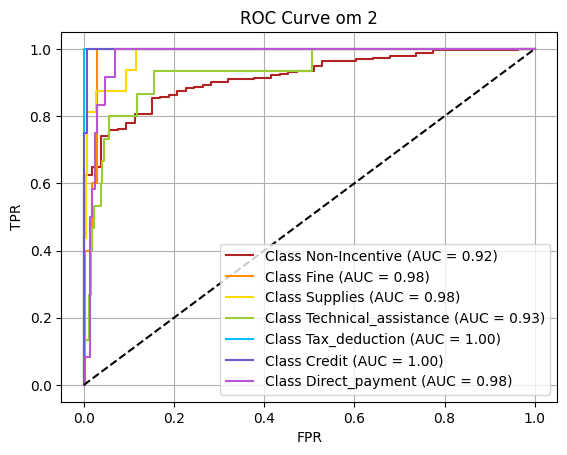

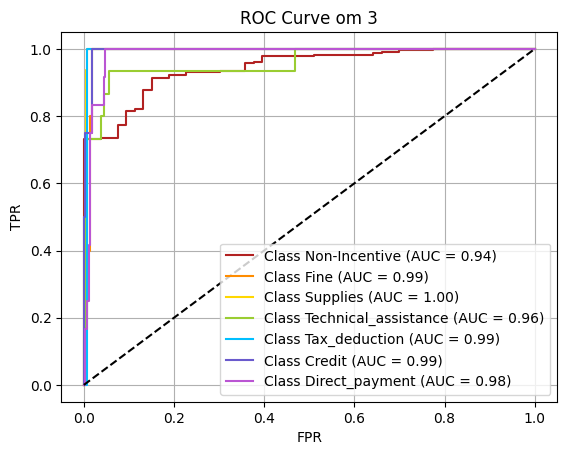

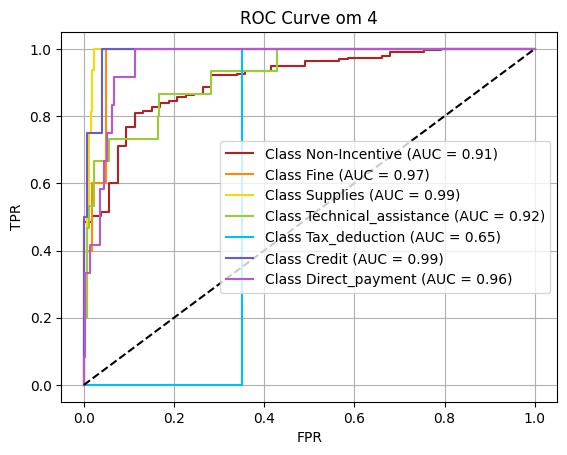

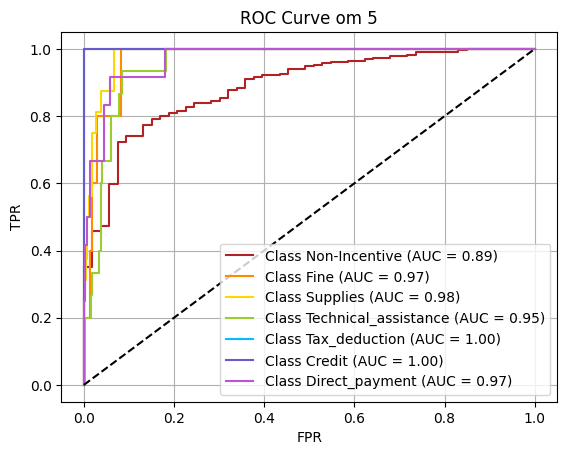

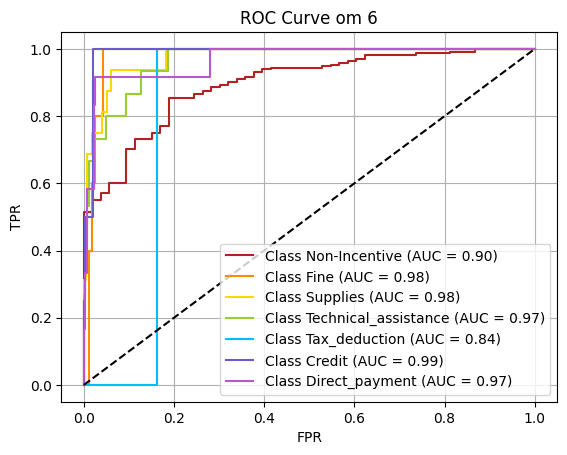

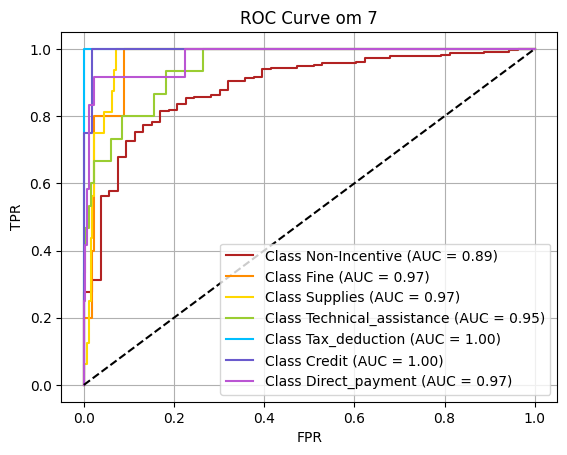

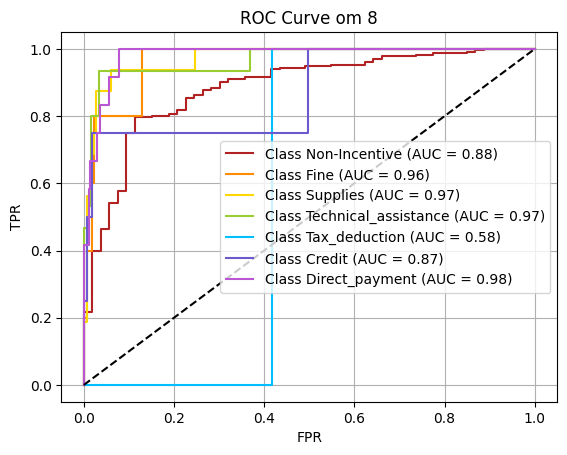

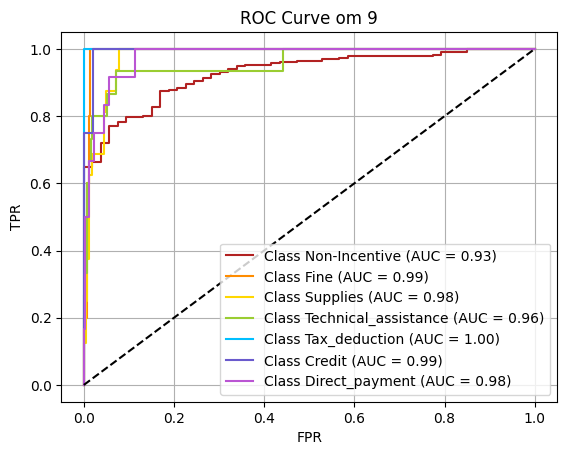

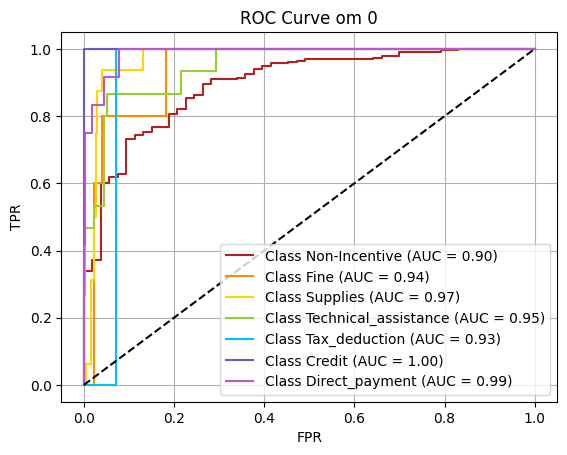

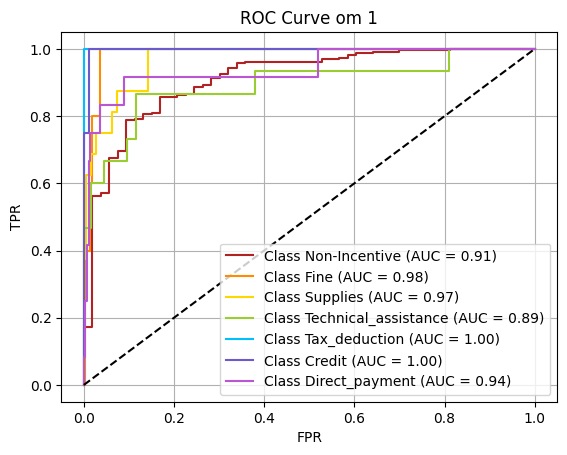

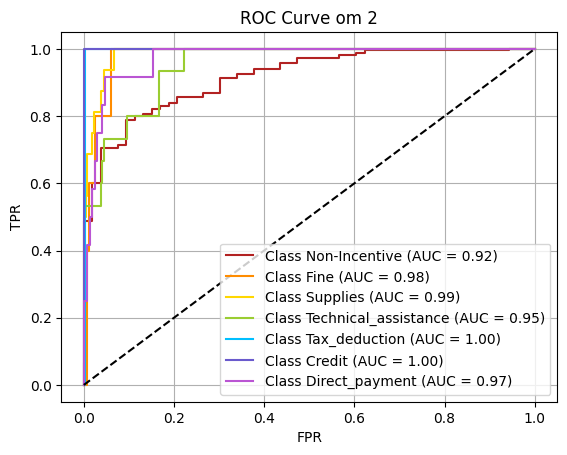

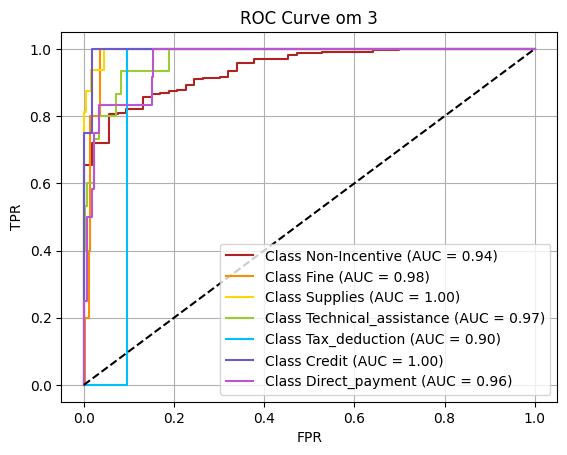

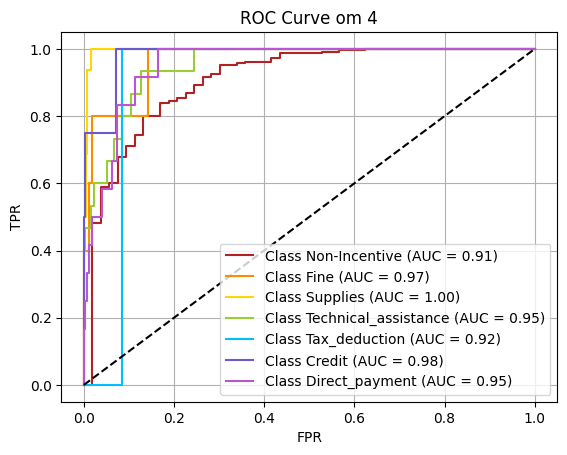

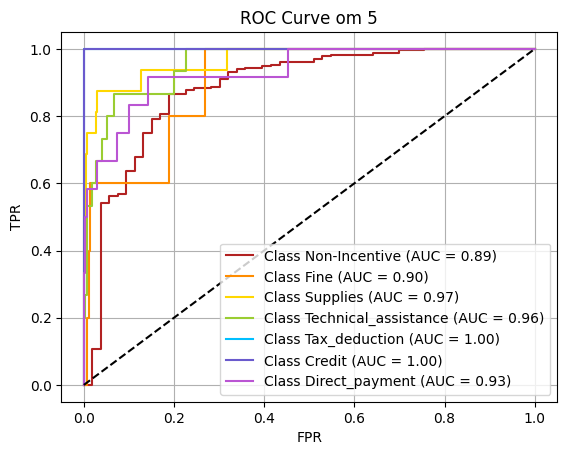

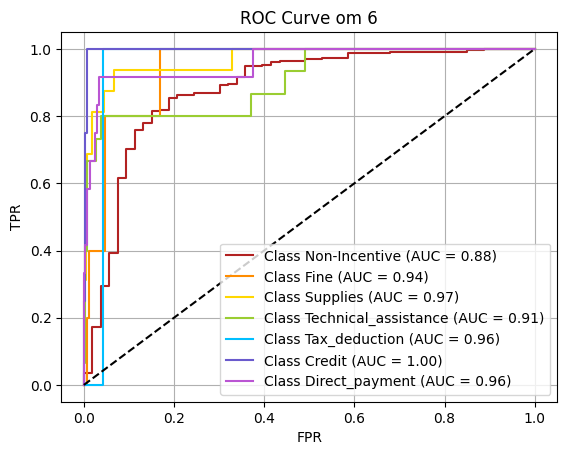

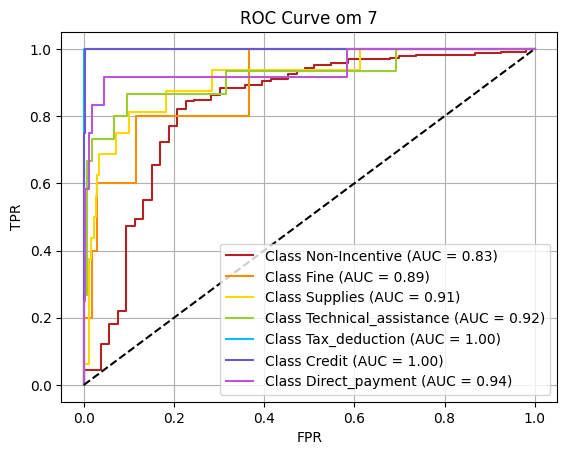

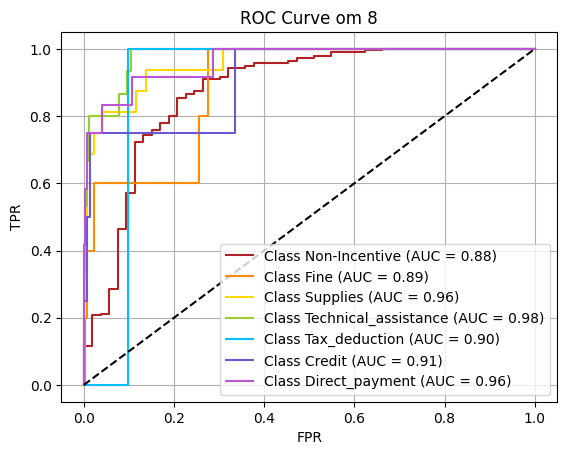

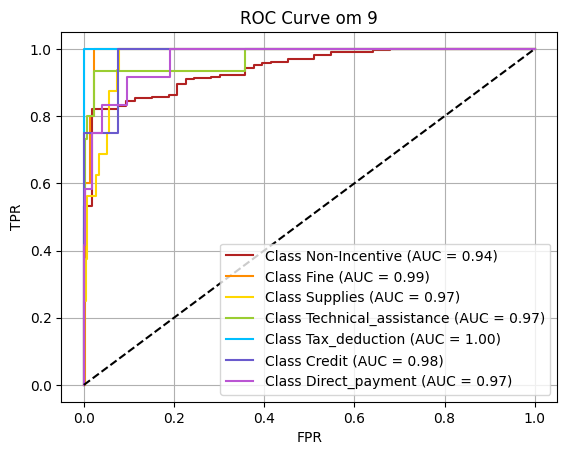

In [ ]:
for r in exps:
    output_dir = cwd+"/outputs/fting_K_om"
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_om")
    hyper = {
        "epochs":10, 
        "r":r, 
        "lr":1E-5,
        "batch_size":8,
        "loss":[0.175,8.81,2.57,2.78,25.3,10.7,3.32],
        "oversampling":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    wandbrun = wandb.init(config=hyper, group="K", name=f"K{r}")
    metrics = finetune_roberta(ds, int2label_dct["om"], label2int_dct["om"], "om", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, report_to="wandb")
    wandbrun.finish()
    metriclog[f'om_{r}'] = metrics
    hyp_rpt = {"om":hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)

for r in exps:
    output_dir = cwd+"/outputs/fting_L_om"
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_om")
    hyper = {
        "epochs":10, 
        "r":r, 
        "lr":1E-5,
        "batch_size":8,
        "loss":None,
        "oversampling":"auto"
        }
    torch.cuda.empty_cache()
    gc.collect()
    wandbrun = wandb.init(config=hyper, group="L", name=f"L{r}")
    metrics = finetune_roberta(ds, int2label_dct["om"], label2int_dct["om"], "om", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, report_to="wandb")
    wandbrun.finish()
    metriclog[f'om_{r}'] = metrics
    hyp_rpt = {"om":hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)

Then test the model by using it to predict labels, or by using it as an embedder with an external classifier that predicts labels

In [ ]:
from classifier.ft_classification import run_experiments, modelpred_dsdct_clsf, svm_dsdct_clsf
from classifier.run_classifiers import res_dct_to_cls_rpt, cls_rpt_to_exp_rpt
from classifier.finetune import load_labelintdcts
from tqdm import tqdm
int2label_dct, label2int_dct = load_labelintdcts()
outfn = "13Apr"
#output_dir = cwd+"/outputs/fting_G_bn"
output_dir = cwd+"/outputs/fting_J_mc"

models = {}
for i in exps:#[0,3,6,9]:#range(10):
    #models[f'bert_bn_e5_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_bn_e5_r{i}.pt'
    #models[f'bert_bn_e10_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_bn_e10_r{i}.pt'
    models[f'bert_mc_e15_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_mc_e15_r{i}.pt'
print(list(models))
model_res_dict = {'bn':{}, 'mc':{}}
svm_res_dict = {'bn':{}, 'mc':{}}
stw = time.time()
for model in tqdm(models):
    print(f'\nRunning model {model}')
    #print(torch.cuda.memory_allocated() / 1e9, "GB allocated before model")
    #print(torch.cuda.memory_reserved() / 1e9, "GB reserved before model")
    st = time.time()
    mode = model.split('_')[1]
    torch.cuda.empty_cache()
    if mode=='bn':
        r = model.split('_')[-1][1:]
        if r == "h":
            r = model.split('_')[-2][1:]
        try:
            dsdct = DatasetDict.load_from_disk(input_dir+f"/ds_{r}_bn")
            model_res_dict[mode][model] = modelpred_dsdct_clsf(dsdct, int2label_dct[mode], label2int_dct[mode], models[model], cuda=True)
            svm_res_dict[mode][model] = svm_dsdct_clsf(dsdct, models[model], cuda=True)
        except Exception as e:
            print(f"\nError in {model}: {e}\n")
    else:
        r = model.split('_')[-1][1:]
        try:
            dsdct = DatasetDict.load_from_disk(input_dir+f"/ds_{r}_mc")
            model_res_dict[mode][model] = modelpred_dsdct_clsf(dsdct, int2label_dct[mode], label2int_dct[mode], models[model], cuda=True)
            svm_res_dict[mode][model] = svm_dsdct_clsf(dsdct, models[model], cuda=True)
        except Exception as e:
            print(f"\nError in {model}: {e}\n")
    print(f"{model} run completed in in {round(time.time()-st,2)}s")
    torch.cuda.empty_cache()
    #gc.collect()
etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")

In [ ]:
with open(f"{output_dir}/randp_{outfn}_model.json", 'w', encoding="utf-8") as outfile:
    json.dump(model_res_dict, outfile, ensure_ascii=False, indent=4)
with open(f"{output_dir}/randp_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_res_dict, outfile, ensure_ascii=False, indent=4)
mdl_cls_rpt = res_dct_to_cls_rpt(model_res_dict, int2label_dct)
mdl_exp_rpt = cls_rpt_to_exp_rpt(mdl_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_mdl.json", 'w', encoding="utf-8") as outfile:
    json.dump(mdl_exp_rpt, outfile, ensure_ascii=False, indent=4)
svm_cls_rpt = res_dct_to_cls_rpt(svm_res_dict, int2label_dct)
svm_exp_rpt = cls_rpt_to_exp_rpt(svm_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_exp_rpt, outfile, ensure_ascii=False, indent=4)

print(f"finished {outfn}")